In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('Mall_Customers.csv')
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [3]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [16]:
# 1) 性别编码
df['Genre_encoded'] = df['Genre'].map({'Male': 0, 'Female': 1})

# 2) 比例特征
eps = 1e-3  # 防止除以 0
df['Spending_per_Income'] = df['Spending Score (1-100)'] / (df['Annual Income (k$)'] + eps)
df['Income_per_Age'] = df['Annual Income (k$)'] / (df['Age'] + eps)

# 3) 非线性单变量
df['Age_sq'] = df['Age'] ** 2
df['Income_sq'] = df['Annual Income (k$)'] ** 2

# 4) 分段/分层特征
# 年龄段：0:≤25, 1:26–35, 2:36–50, 3:>50
df['Age_group'] = pd.cut(
    df['Age'],
    bins=[0, 25, 35, 50, 120],
    labels=[0, 1, 2, 3],
    include_lowest=True
).astype(int)

# 收入档位：0:低收入, 1:中收入, 2:高收入（阈值可按你数据调整）
df['Income_tier'] = pd.cut(
    df['Annual Income (k$)'],
    bins=[0, 40, 70, 200],
    labels=[0, 1, 2],
    include_lowest=True
).astype(int)

# 5) 选取最终用于聚类的特征列表
features = [
    'Genre_encoded',
    'Age',
    'Annual Income (k$)',
    'Spending Score (1-100)',
    'Spending_per_Income',
    'Income_per_Age',
    'Age_sq',
    'Income_sq',
    'Age_group',
    'Income_tier'
]

X = df[features].copy()


In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

d:\APP\Data\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\APP\Data\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\APP\Data\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\APP\Data\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when

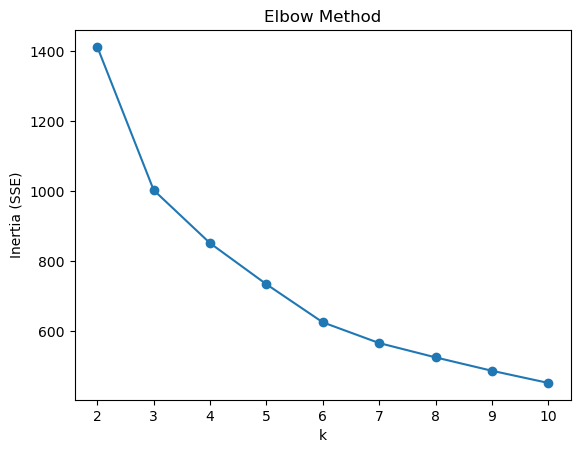

In [20]:
inertias = []
K_list = range(2, 11)

for k in K_list:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)  # SSE

plt.figure()
plt.plot(K_list, inertias, marker='o')
plt.xlabel('k')
plt.ylabel('Inertia (SSE)')
plt.title('Elbow Method')
plt.show()


d:\APP\Data\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\APP\Data\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\APP\Data\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\APP\Data\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when

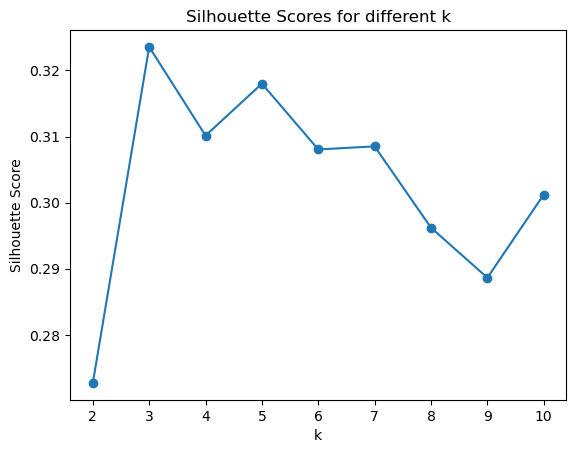

Best k by silhouette: 3


In [21]:
sil_scores = []
for k in K_list:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)

plt.figure()
plt.plot(K_list, sil_scores, marker='o')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for different k')
plt.show()

best_k = K_list[int(np.argmax(sil_scores))]
print("Best k by silhouette:", best_k)


In [22]:
best_k = 3

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

df['Cluster'] = cluster_labels
print(df[['CustomerID', 'Genre', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Cluster']].head())


   CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)  \
0           1    Male   19                  15                      39   
1           2    Male   21                  15                      81   
2           3  Female   20                  16                       6   
3           4  Female   23                  16                      77   
4           5  Female   31                  17                      40   

   Cluster  
0        2  
1        2  
2        2  
3        2  
4        2  


d:\APP\Data\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


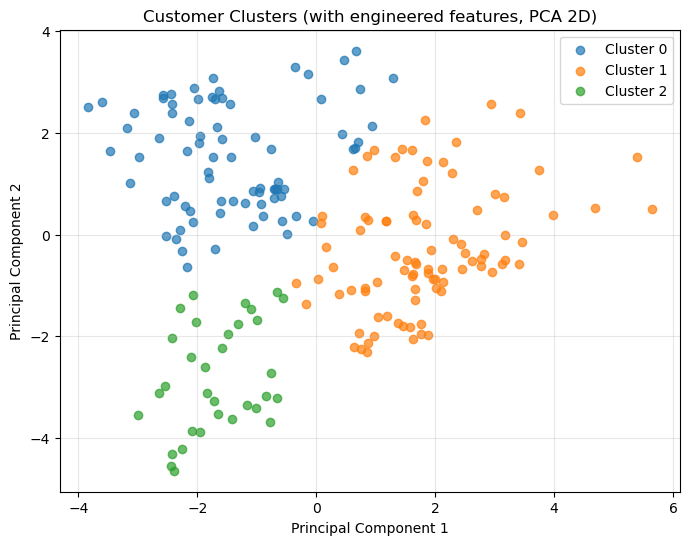

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 用 PCA 把二级特征降到 2 维
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

df['PC1'] = X_pca[:, 0]
df['PC2'] = X_pca[:, 1]

plt.figure(figsize=(8, 6))
for c in sorted(df['Cluster'].unique()):
    sub = df[df['Cluster'] == c]
    plt.scatter(sub['PC1'], sub['PC2'], alpha=0.7, label=f'Cluster {c}')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Customer Clusters (with engineered features, PCA 2D)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [25]:
# 每个簇的样本数
cluster_counts = df['Cluster'].value_counts().sort_index()
print("Cluster sizes:")
print(cluster_counts)

# 每个簇在关键特征上的均值
key_cols = [
    'Age', 'Annual Income (k$)', 'Spending Score (1-100)',
    'Spending_per_Income', 'Income_per_Age', 'Age_group', 'Income_tier'
]
cluster_profile = df.groupby('Cluster')[key_cols].mean().round(2)

print("\nCluster profile (mean values):")
print(cluster_profile)


Cluster sizes:
Cluster
0    77
1    90
2    33
Name: count, dtype: int64

Cluster profile (mean values):
           Age  Annual Income (k$)  Spending Score (1-100)  \
Cluster                                                      
0        53.26               52.57                   37.14   
1        31.01               79.57                   55.26   
2        26.61               27.36                   66.88   

         Spending_per_Income  Income_per_Age  Age_group  Income_tier  
Cluster                                                               
0                       0.75            1.01       2.51         0.91  
1                       0.73            2.64       1.06         1.69  
2                       2.73            1.06       0.48         0.06  


In [35]:
df['HighSpender'] = (df['Spending Score (1-100)'] > 70).astype(int)
df['HighIncome']  = (df['Annual Income (k$)'] > 78).astype(int)

df['female'] = (df['Genre_encoded'] == 1).astype(int)
df['male']   = (df['Genre_encoded'] == 0).astype(int)

df['young'] = (df['Age'] < 29).astype(int)
df['old']   = (df['Age'] >= 49).astype(int)

df['young_female'] = ( (df['Age'] < 29) & (df['Genre_encoded'] == 1)).astype(int)


cluster_value_stats = df.groupby('Cluster')[['HighSpender', 'HighIncome','female', 'young', 'old', 'young_female']].mean().round(3)
print("\nHigh-value ratios:")
print(cluster_value_stats)



High-value ratios:
         HighSpender  HighIncome  female  young    old  young_female
Cluster                                                             
0              0.000       0.078   0.558  0.000  0.675         0.000
1              0.389       0.378   0.533  0.356  0.000         0.156
2              0.576       0.000   0.636  0.545  0.000         0.333


In [37]:
import pandas as pd

# --- 1. 年龄段（Age_group 0/1/2/3）分布 ---
age_group_dist = (
    df.groupby("Cluster")["Age_group"]
      .value_counts(normalize=True)
      .unstack()
      .add_prefix("AgeGroup_")
      .fillna(0)
)

# --- 2. 收入段（Income_tier 0/1/2）分布 ---
income_tier_dist = (
    df.groupby("Cluster")["Income_tier"]
      .value_counts(normalize=True)
      .unstack()
      .add_prefix("IncomeTier_")
      .fillna(0)
)

# --- 3. 合并成一个完整表 ---
table = age_group_dist.join(income_tier_dist, how="left")

# 显示完整列
pd.set_option("display.max_columns", None)
print("簇档位分布")
print(table)


簇档位分布
         AgeGroup_0  AgeGroup_1  AgeGroup_2  AgeGroup_3  IncomeTier_0  \
Cluster                                                                 
0          0.000000    0.012987    0.467532    0.519481      0.246753   
1          0.233333    0.477778    0.288889    0.000000      0.000000   
2          0.515152    0.484848    0.000000    0.000000      0.939394   

         IncomeTier_1  IncomeTier_2  
Cluster                              
0            0.597403      0.155844  
1            0.311111      0.688889  
2            0.060606      0.000000  


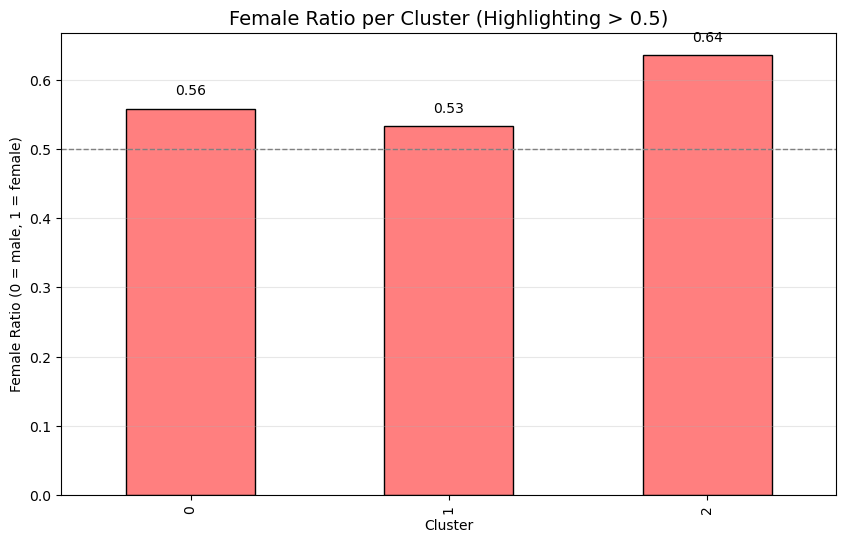

In [ ]:
import matplotlib.pyplot as plt

gender_stats = df.groupby("Cluster")['Genre_encoded'].mean()

colors = ['#ff7f7f' if v > 0.5 else '#6fa8dc' for v in gender_stats]

plt.figure(figsize=(10,6))

gender_stats.plot(
    kind='bar',
    color=colors,
    edgecolor='black'
)

# 添加 0.5 基线
plt.axhline(0.5, color='gray', linestyle='--', linewidth=1)

plt.title("Female Ratio per Cluster", fontsize=14)
plt.xlabel("Cluster")
plt.ylabel("Female Ratio (0 = male, 1 = female)")
plt.grid(axis='y', alpha=0.3)

# 添加标签（百分比）
for i, v in enumerate(gender_stats):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=10)

plt.show()


# **Customer Segmentation Analysis**

Using K-Means clustering with both original and engineered features (e.g., spending efficiency, income-per-age, age group, and income tier), the customer base was segmented into three distinct clusters. The segmentation reveals clear structural differences in demographic characteristics, purchasing behavior, and income profiles.

---

## **Cluster 0 – Older, Mid-Income, Low-Spending Consumers**

**Key statistics:**

* **Average age:** 53.26
* **Average annual income:** 52.57k
* **Average spending score:** 37.14
* **Spending per income:** 0.75
* **Age group mean:** 2.51 (primarily 36–50 and 50+)
* **Income tier:** 0.91 (mostly mid-income)

**Interpretation:**
Cluster 0 consists predominantly of **older customers with mid-level income and consistently low spending behavior**. Their spending efficiency is the lowest among all clusters, indicating **very conservative purchasing behavior** despite moderate income levels.
This cluster represents a **large and stable but low-value segment**, unlikely to respond to aggressive marketing campaigns but suitable for long-term, low-cost engagement strategies.

---

## **Cluster 1 – Young to Mid-Age, High-Income, Moderate-Spending Consumers**

**Key statistics:**

* **Average age:** 31.01
* **Average annual income:** 79.57k
* **Average spending score:** 55.26
* **Spending per income:** 0.73
* **Age group mean:** 1.06 (mainly ages 26–35)
* **Income tier:** 1.69 (mainly high-income)

**Interpretation:**
Cluster 1 represents a **younger, financially strong customer segment**. Although their income is the highest across all clusters, their average spending score is only moderate. This suggests **latent consumption potential**: these customers have the ability to spend more but are not currently doing so.
This group is ideal for **targeted marketing, premium product recommendations**, and **loyalty programs** aimed at activating higher spending.

---

## **Cluster 2 – Very Young, Low-Income but High-Spending Consumers**

**Key statistics:**

* **Average age:** 26.61
* **Average annual income:** 27.36k
* **Average spending score:** 66.88
* **Spending per income:** 2.73 (highest among all clusters)
* **Age group mean:** 0.48 (mainly ≤25)
* **Income tier:** 0.06 (mostly low-income)

**Interpretation:**
Cluster 2 is the most behaviorally unique segment: despite having the **lowest income**, they show the **highest spending score** and an extremely high **spending-per-income ratio**. This indicates a group of **highly active, consumption-driven younger customers**, who are likely to respond strongly to promotions, social-media campaigns, and discount-driven marketing.
This segment is small but **highly valuable in terms of engagement**, and could become long-term high-LTV customers if retained effectively.

---

# **Comparative Insights and Managerial Implications**

1. **Cluster 0** is a *large but low-value* group. Marketing resources should be minimized; focus instead on retention through basic membership benefits or essential-needs products.

2. **Cluster 1** has the *highest income but only moderate spending*. This indicates significant *untapped potential*. Personalized recommendations, premium product bundles, and loyalty incentives are likely to increase their spending.

3. **Cluster 2** is a *high-engagement, young consumer group* with the strongest spending activity relative to income. This segment is ideal for promotional campaigns, influencer marketing, and gamified loyalty programs.

---

# **Overall Conclusion**

The segmentation successfully identifies **three behaviorally and demographically distinct customer groups**:

* **(0)** older conservative spenders,
* **(1)** affluent but under-engaged young professionals,
* **(2)** young high-engagement consumers with strong spending motivation.

These insights provide a clear basis for **differentiated marketing strategy**, resource allocation, and future customer relationship management.

d:\APP\Data\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\APP\Data\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\APP\Data\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\APP\Data\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when

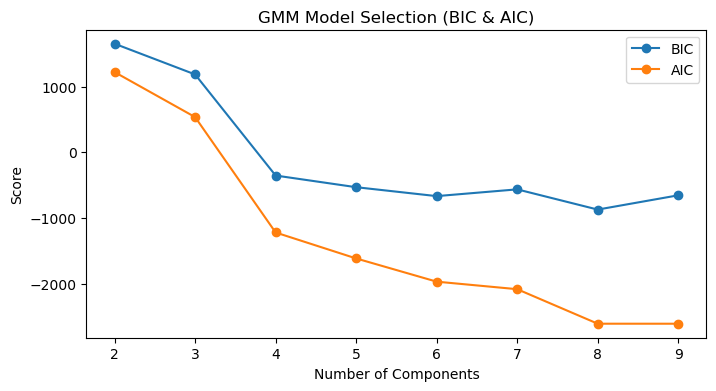

Best number of components by BIC: 8
Cluster counts:
GMM_Cluster
3    35
6    32
0    26
7    25
2    23
5    23
4    22
1    14
Name: count, dtype: int64


d:\APP\Data\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


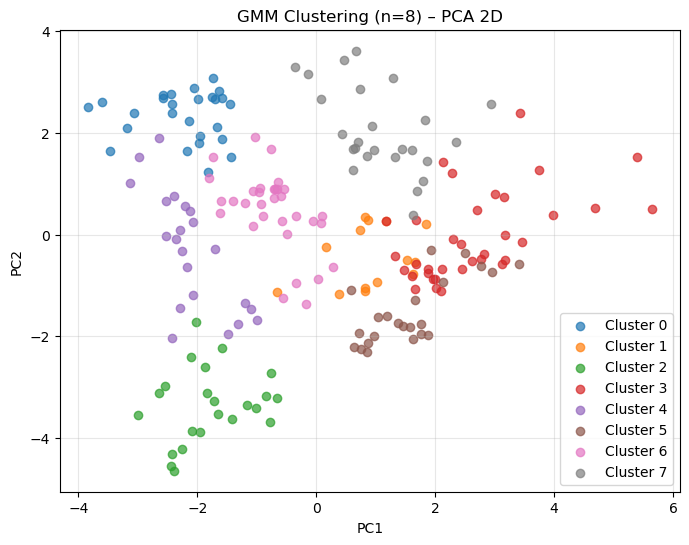


GMM Cluster Centers (unscaled):
   Genre_encoded        Age  Annual Income (k$)  Spending Score (1-100)  \
0       0.423026  63.654534           48.268559               44.229703   
1       0.068778  33.778789           70.168493               77.268395   
2       0.565226  24.999957           25.260935               77.608440   
3       0.698029  32.483744           94.494139               70.888443   
4       0.772715  39.772816           30.136287               28.091170   
5       0.521739  21.260872           63.086955               41.086962   
6       0.718773  44.156962           55.593863               48.156950   
7       0.435936  46.197502           84.184593               16.999896   

   Spending_per_Income  Income_per_Age       Age_sq    Income_sq  Age_group  \
0             0.892450        0.760519  4073.198970  2508.288858   3.000000   
1             1.107906        2.098954  1163.390066  5055.006491   1.410219   
2             3.335285        1.052060   651.866833   

In [39]:
from sklearn.mixture import GaussianMixture

n_components = np.arange(2, 10)
bics = []
aics = []

for n in n_components:
    gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=42)
    gmm.fit(X_scaled)
    bics.append(gmm.bic(X_scaled))
    aics.append(gmm.aic(X_scaled))

plt.figure(figsize=(8,4))
plt.plot(n_components, bics, marker='o', label='BIC')
plt.plot(n_components, aics, marker='o', label='AIC')
plt.xlabel("Number of Components")
plt.ylabel("Score")
plt.title("GMM Model Selection (BIC & AIC)")
plt.legend()
plt.show()

best_n = n_components[np.argmin(bics)]
print("Best number of components by BIC:", best_n)

# ---------------------------------------
# 2. 训练最终的 GMM 模型
# ---------------------------------------
gmm = GaussianMixture(
    n_components=best_n,
    covariance_type='full',
    random_state=42
)
gmm.fit(X_scaled)

# 簇标签（硬分类）
gmm_labels = gmm.predict(X_scaled)

# 每个样本属于各簇的概率（软分类）
gmm_probs = gmm.predict_proba(X_scaled)

df['GMM_Cluster'] = gmm_labels

print("Cluster counts:")
print(df['GMM_Cluster'].value_counts())

# ---------------------------------------
# 3. PCA 2D 可视化
# ---------------------------------------
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
df['PC1'] = X_pca[:, 0]
df['PC2'] = X_pca[:, 1]

plt.figure(figsize=(8,6))
for c in range(best_n):
    sub = df[df['GMM_Cluster'] == c]
    plt.scatter(sub['PC1'], sub['PC2'], alpha=0.7, label=f'Cluster {c}')

plt.title(f'GMM Clustering (n={best_n}) – PCA 2D')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# ---------------------------------------
# 4. 查看 GMM 聚类中心（在标准化空间）
# ---------------------------------------
centers_scaled = gmm.means_

# 把中心反标准化
centers = scaler.inverse_transform(centers_scaled)
centers_df = pd.DataFrame(centers, columns=features)
print("\nGMM Cluster Centers (unscaled):")
print(centers_df)

# ---------------------------------------
# 5. 各簇特征均值（实际更常用于分析）
# ---------------------------------------
gmm_profile = df.groupby('GMM_Cluster')[features].mean()
print("\nCluster Profile Means:")
print(gmm_profile)

# ---------------------------------------
# 6. 如果你需要每个点的“最可信簇”的概率
# ---------------------------------------
df['MaxProb'] = gmm_probs.max(axis=1)


The Gaussian Mixture Model produced eight well-differentiated customer segments.
Including gender in the interpretation reveals essential behavioral patterns that would be missed by demographic-only analysis.



# **Cluster-by-Cluster Interpretation**


## **Cluster 0 – Older, Mid-Income, Male-Majority, Moderate-Spenders**

**Center characteristics:**

* **Age:** 63.7 (oldest group)
* **Income:** 48.3k
* **Spending Score:** 44.2
* **Gender:** 0.423 → **male-majority**
* **Spending per Income:** 0.89

**Interpretation:**
This segment consists primarily of **older male consumers** with mid-level income and moderate spending. They show conservative purchasing behavior typical of senior male groups who focus on essential, low-frequency purchases.
→ Suitable for basic membership retention, not aggressive marketing.


## **Cluster 1 – Young Professionals, High Income, Strongly Male-Dominant, High Spenders**

**Center characteristics:**

* **Age:** 33.8
* **Income:** 70.2k
* **Spending Score:** 77.3
* **Gender:** 0.068 → **overwhelmingly male**
* **Spending per Income:** 1.11

**Interpretation:**
This is a **high-income, young male** cluster showing strong discretionary spending.
→ Excellent target for **tech products, electronics, premium lifestyle goods**, and experience-based services.


## **Cluster 2 – Very Young, Low-Income, Female-Majority Impulsive Spenders**

**Center characteristics:**

* **Age:** 25.0
* **Income:** 25.3k
* **Spending Score:** 77.6
* **Gender:** 0.565 → **female-majority**
* **Spending per Income:** 3.34 (highest)

**Interpretation:**
This cluster consists of **young, low-income but high-engagement female-heavy consumers**, displaying the highest spending-per-income ratio.
→ Ideal for **fast fashion, beauty, entertainment, social-media driven marketing**.


## **Cluster 3 – Mid-Age, Very High Income, Female-Dominant, Moderate Spenders**

**Center characteristics:**

* **Age:** 32.5
* **Income:** 94.5k
* **Spending Score:** 70.9
* **Gender:** 0.698 → **female-dominant**
* **Spending per Income:** 0.80

**Interpretation:**
A financially strong female-oriented group with controlled but healthy spending behavior.
→ Strong potential for **premium retail, wellness, boutique fashion, subscription plans**.

## **Cluster 4 – Mid-Age, Low-Income, Strongly Female-Dominant, Low Spenders**

**Center characteristics:**

* **Age:** 39.8
* **Income:** 30.1k
* **Spending Score:** 28.1 (very low)
* **Gender:** 0.773 → **strong female dominance**
* **Spending per Income:** 0.94

**Interpretation:**
This group contains **budget-constrained mid-age women** with very low engagement.
→ Best approached with **low-price essential goods**, coupons, and price-protection programs.

## **Cluster 5 – Very Young, Mid-Income, Gender-Balanced, Low Spenders**

**Center characteristics:**

* **Age:** 21.3
* **Income:** 63.1k
* **Spending Score:** 41.1
* **Gender:** 0.522 → **balanced, slight female tilt**
* **Spending per Income:** 0.70

**Interpretation:**
A young, emerging customer group with decent income but not yet active spending habits. Gender is nearly balanced.
→ Best for **brand-building, student-to-professional onboarding**, subscription starter products.


## **Cluster 6 – Mid-Age, Mid-Income, Strong Female Majority, Moderate Spending**

**Center characteristics:**

* **Age:** 44.2
* **Income:** 55.6k
* **Spending Score:** 48.2
* **Gender:** 0.718 → **strongly female**
* **Spending per Income:** 0.88

**Interpretation:**
This mid-age female-majority group exhibits reasonable income and balanced consumption.
→ Suitable for **family-oriented products, household brands, weekly-use goods**.


## **Cluster 7 – Mid-Age, High Income, Male-Majority, Very Low Spenders**

**Center characteristics:**

* **Age:** 46.2
* **Income:** 84.2k
* **Spending Score:** 17.0 (lowest)
* **Gender:** 0.436 → **male-majority**
* **Spending per Income:** 0.20 (extremely low)

**Interpretation:**
This cluster reflects **conservative, financially secure mid-age men** with minimal spending activity.
→ Requires **high-touch targeted engagement**, VIP services, and exclusive event invitations.


#  **Strategic Recommendations (Gender + Behavior Integrated)**

### **Female-driven growth opportunities**

* Cluster 2 → beauty, fashion, entertainment
* Cluster 3 → luxury, wellness, curated subscriptions
* Cluster 6 → household & family-focused campaigns

### **Male-driven growth opportunities**

* Cluster 1 → electronics, automotive, high-end lifestyle
* Cluster 7 → VIP-only offers, exclusive investment-related items

### **Resource Allocation**

* Prioritize clusters 1, 2, 3 for revenue growth
* Maintain low-cost retention for 0 and 4
* Develop targeted strategies for activation in cluster 7

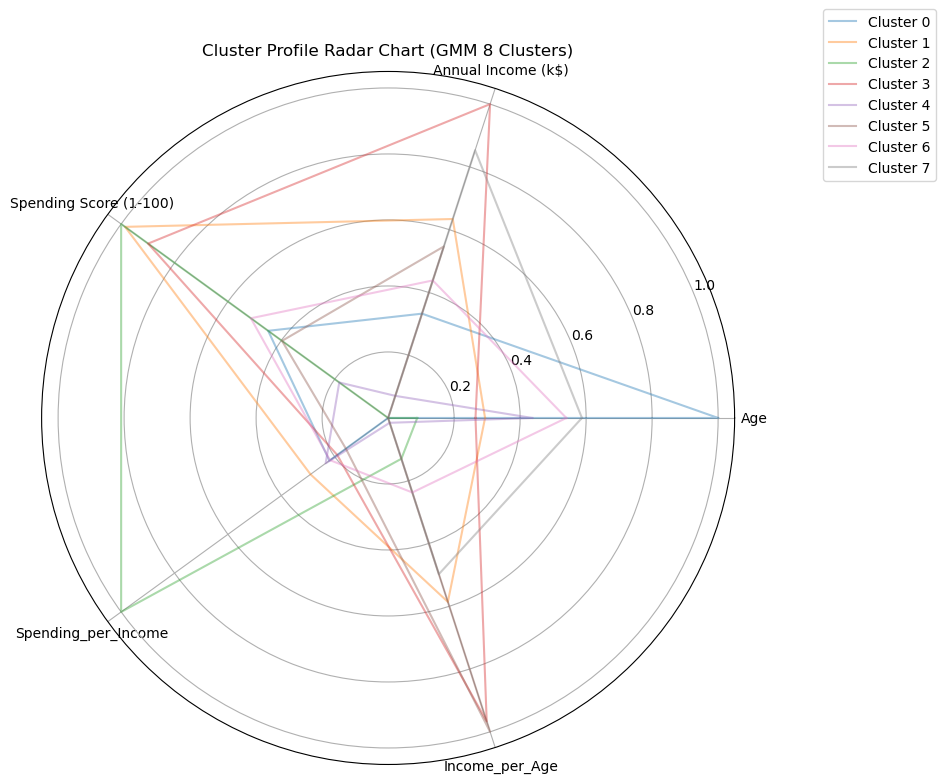

In [41]:
import numpy as np
import matplotlib.pyplot as plt

radar_features = [
    'Age',
    'Annual Income (k$)',
    'Spending Score (1-100)',
    'Spending_per_Income',
    'Income_per_Age'
]

cluster_stats = df.groupby("GMM_Cluster")[radar_features].mean()

# 标准化到 0-1 方便画雷达图
norm = (cluster_stats - cluster_stats.min()) / (cluster_stats.max() - cluster_stats.min())

labels = radar_features
num_vars = len(labels)
angles = np.linspace(0, 2*np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

plt.figure(figsize=(9,9))

for c in norm.index:
    values = norm.loc[c].tolist()
    values += values[:1]
    plt.polar(angles, values, label=f'Cluster {c}', alpha=0.4)

plt.xticks(angles[:-1], labels)
plt.title("Cluster Profile Radar Chart (GMM 8 Clusters)")
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()


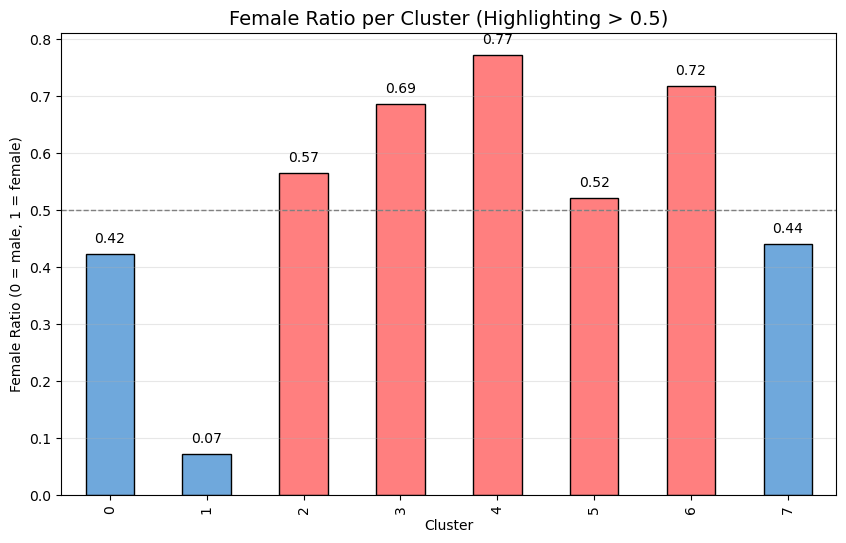

In [ ]:
import matplotlib.pyplot as plt

gender_stats = df.groupby("GMM_Cluster")['Genre_encoded'].mean()

colors = ['#ff7f7f' if v > 0.5 else '#6fa8dc' for v in gender_stats]

plt.figure(figsize=(10,6))

gender_stats.plot(
    kind='bar',
    color=colors,
    edgecolor='black'
)

# 添加 0.5 基线
plt.axhline(0.5, color='gray', linestyle='--', linewidth=1)

plt.title("Female Ratio per Cluster", fontsize=14)
plt.xlabel("Cluster")
plt.ylabel("Female Ratio (0 = male, 1 = female)")
plt.grid(axis='y', alpha=0.3)

# 添加标签（百分比）
for i, v in enumerate(gender_stats):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=10)

plt.show()
